In [13]:
import copy
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, "../src/")


In [14]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['figure.dpi'] = 85
mpl.rcParams['axes.labelsize'] = 'large'

# This is the largest possible value of the logloss
logloss_inf_limit = -np.log(np.finfo('float').eps)


In [15]:
# Fixed var
res_path = osp.join('..', 'output', 'real_data_20200827_140859', 'results.csv')

# Adaptive var
res_path = osp.join('..', 'output', 'real_data_20200827_150854', 'results.csv')



res_df = pd.read_csv(res_path)
print(res_df.columns)
res_df.head(3)


Index(['dataset_name', 'trainset_size', 'trail_num', 'valset_size',
       'testset_size', 'num_features', 'mn_test_logloss', 'mn_test_mse',
       'mn_theta_norm', 'mn_variance', 'mn_adaptive_var_test_logloss',
       'mn_adaptive_var_variance', 'genie_adaptive_var_test_logloss',
       'genie_test_logloss', 'genie_test_mse', 'genie_theta_norm',
       'genie_adaptive_var_variance', 'genie_variance',
       'empirical_pnml_regret', 'empirical_pnml_test_logloss',
       'analytical_pnml_regret', 'analytical_pnml_test_logloss',
       'mdl_lambda_opt', 'mdl_test_mse', 'mdl_theta_norm', 'mdl_test_logloss',
       'mdl_variance', 'mdl_adaptive_var_test_logloss',
       'mdl_adaptive_var_variance', 'test_idx'],
      dtype='object')


,dataset_name,trainset_size,trail_num,valset_size,testset_size,num_features,mn_test_logloss,mn_test_mse,mn_theta_norm,mn_variance,...,analytical_pnml_regret,analytical_pnml_test_logloss,mdl_lambda_opt,mdl_test_mse,mdl_theta_norm,mdl_test_logloss,mdl_variance,mdl_adaptive_var_test_logloss,mdl_adaptive_var_variance,test_idx
0,645_fri_c3_500_50,2,0,100,100,51,1.661590,1.388753,0.071889,0.831937,...,1.624975,1.329757,[44.21217824],0.875049,0.025968,1.352848,0.831999,1.417850,0.545724,0
1,645_fri_c3_500_50,2,0,100,100,51,0.864804,0.063003,0.071889,0.831937,...,3.502601,-0.120035,[44.21217824],0.084458,0.025968,0.877733,0.831999,0.436004,0.282194,1
2,645_fri_c3_500_50,2,0,100,100,51,3.477190,4.409682,0.071889,0.831937,...,1.047072,2.529836,[44.21217824],4.893122,0.025968,3.767558,0.831999,2.533778,1.885082,2


In [17]:
# Filter negative regrets
len_before = len(res_df)
res_df = res_df[res_df['empirical_pnml_regret'] > 0]
len_after = len(res_df)
if len_after != len_before:
    print(f'Dropped {len_before-len_after} rows from {len_before}')

   mn_test_logloss  mdl_adaptive_var_test_logloss  \
0         1.364554                       1.024828   
1         1.313358                       1.041145   
2         1.587174                       1.239631   
3         1.346736                       1.228115   

   empirical_pnml_test_logloss  analytical_pnml_test_logloss  \
0                     0.532796                      0.562679   
1                     0.851917                      0.910050   
2                     0.786983                      0.806859   
3                     0.769099                      0.729552   

   mn_adaptive_var_test_logloss  mdl_test_logloss  \
0                      1.118814          1.343037   
1                      1.344616          1.319993   
2                      2.855057          1.447424   
3                      5.993617          1.282744   

   mdl_adaptive_var_test_logloss  genie_test_logloss  \
0                       1.024828            0.927792   
1                       1.041145   

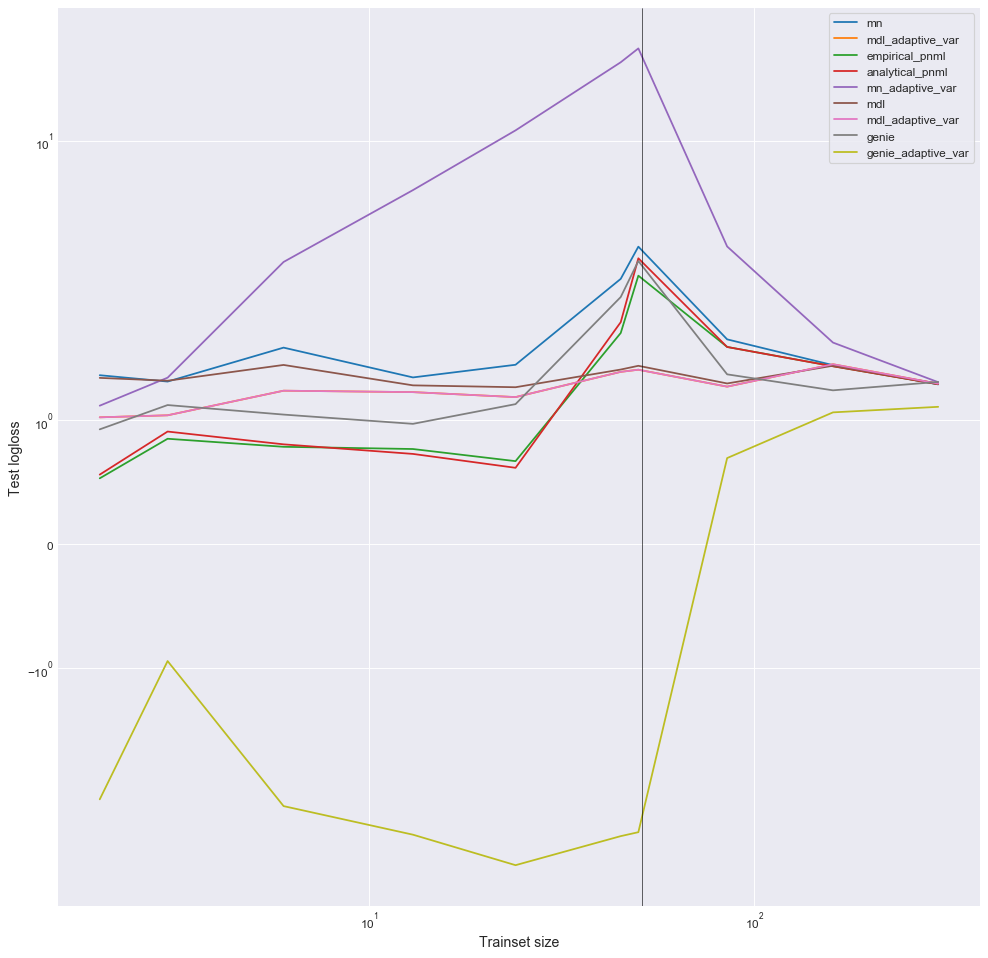

In [24]:
# Create mean df
res_mean_df = res_df.groupby('trainset_size').mean().reset_index()

# Plot learners logloss
keys = ['mn',
        'mdl_adaptive_var',
        'empirical_pnml',
        'analytical_pnml',
        'mn_adaptive_var',
        'mdl',
        'mdl_adaptive_var',
        'genie',
        'genie_adaptive_var']

loglos_mean_df = res_mean_df[[key + '_test_logloss' for key in keys] + ['trainset_size']]
print(loglos_mean_df.head(4))

fig,ax = plt.subplots(1,1,figsize=(14,14))
for key in keys:
    plt.plot(res_mean_df['trainset_size'], res_mean_df[key + '_test_logloss'], label=key)
    plt.legend()
plt.axvline(res_mean_df['num_features'].mean(), color='black', linewidth=0.5)
plt.ylabel('Test logloss')
plt.xlabel('Trainset size')
plt.xscale('log')
plt.yscale('symlog')
plt.show()


In [8]:
# Choose specific configurations
dataset_name = '645_fri_c3_500_50'
print('trainset_size: ', res_mean_df.trainset_size.unique())
trainset_size = 51
trail_num = 0
df = res_df[(res_df['dataset_name'] == dataset_name) & \
            (res_df['trainset_size'] == trainset_size) & \
            (res_df['trail_num'] == trail_num)
            ]
df

trainset_size:  [  2   3   6  10  18  32  50  56  98 171 300]


,dataset_name,trainset_size,trail_num,valset_size,testset_size,num_features,mn_test_logloss,mn_test_mse,mn_theta_norm,mn_variance,...,analytical_pnml_regret,analytical_pnml_test_logloss,mdl_lambda_opt,mdl_test_mse,mdl_theta_norm,mdl_test_logloss,mdl_variance,mdl_test_logloss_adaptive_var,mdl_variance_adaptive_var,test_idx


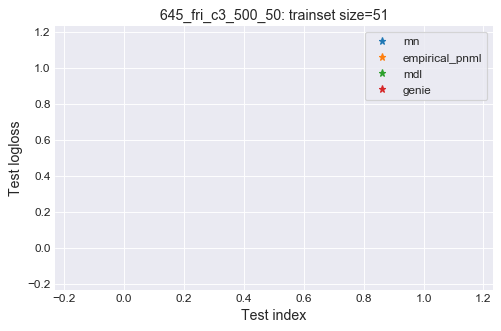

Worst case:
mn_test_logloss               NaN
empirical_pnml_test_logloss   NaN
mdl_test_logloss              NaN
genie_test_logloss            NaN
dtype: float64


In [9]:
# Plot learners logloss for each sample
df_sorted = df.sort_values(by=['mn_test_logloss'])
df_sorted = df_sorted.reset_index()
keys = ['mn',
        'empirical_pnml',
#         'analytical_pnml',
        'mdl',
        'genie']
for key in keys:
    plt.plot(df_sorted[key + '_test_logloss'], '*', label=key)
plt.legend()
plt.title('{}: trainset size={}'.format(dataset_name, trainset_size))
plt.xlabel('Test index')
plt.ylabel('Test logloss')
# plt.xscale('log')
plt.tight_layout()
plt.show()

# Worst case:
print('Worst case:')
print(df_sorted[[key + '_test_logloss' for key in keys]].max())